In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
steel_industry_energy_consumption = fetch_ucirepo(id=851) 
  
# data (as pandas dataframes) 
X = steel_industry_energy_consumption.data.features 
y = steel_industry_energy_consumption.data.targets 
  
# metadata 
print(steel_industry_energy_consumption.metadata) 
# variable information 
print(steel_industry_energy_consumption.variables) 


{'uci_id': 851, 'name': 'Steel Industry Energy Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/851/data.csv', 'abstract': 'The data is collected from a smart small-scale steel industry in South Korea.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 35040, 'num_features': 9, 'feature_types': ['Real', 'Categorical'], 'demographics': [], 'target_col': ['Load_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2021, 'last_updated': 'Mon Aug 14 2023', 'dataset_doi': '10.24432/C52G8C', 'creators': ['Sathishkumar V E', 'Changsun Shin', 'Yongyun Cho'], 'intro_paper': {'title': 'Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city', 'authors': 'Sathishkumar V E, Changsun Shin, Yongyun Cho', 'published

In [2]:
import numpy as np
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=np.number).columns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

y = LabelEncoder().fit_transform(np.ravel(y))

columnTransformer = ColumnTransformer(
    transformers=[
        ('categorical', TargetEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)]
)
X = columnTransformer.fit_transform(X, y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

In [5]:
import torch
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [6]:
class MyDataset(Dataset):

    def __init__(self, X, y, q = 1):
        self.X = torch.tensor(X, dtype = torch.float)
        self.y = torch.tensor(y).long()
        self.q = q
    def __len__(self):
        return self.X.shape[0] - (self.q-1)
    def __getitem__(self, index):
        return (self.X[index:index+self.q], self.y[index+self.q-1])

In [7]:
train_loader = DataLoader(MyDataset(X_train, y_train, 5), batch_size = 64, shuffle = False)
test_loader = DataLoader(MyDataset(X_test, y_test, 5), batch_size = 64, shuffle = False)

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [83]:
class RNN_Classifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.RNN(input_size = in_features, hidden_size = hidden_size, batch_first = True, nonlinearity='relu')
        self.head = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        return self.head(out[-1])

In [84]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [85]:
from tqdm.notebook import tqdm
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.shape[0]
        train_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})


  0%|          | 0/100 [00:00<?, ?it/s]

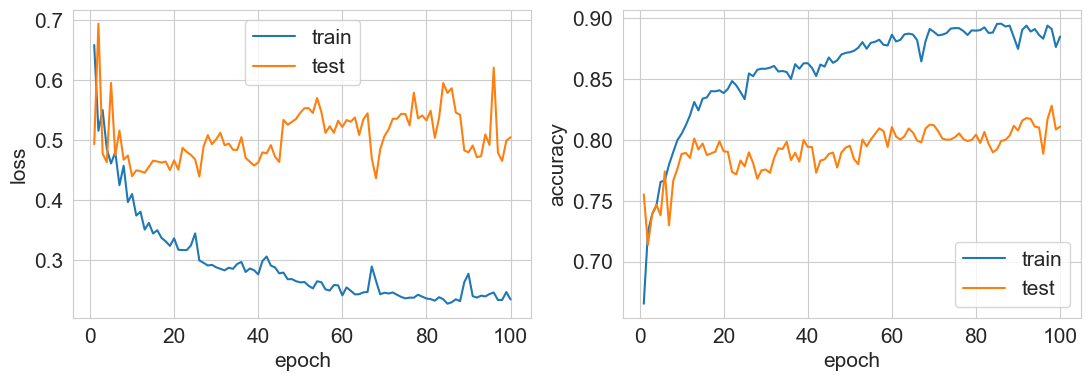

In [86]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)


In [87]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.2340349297731636
test loss 0.5048356212627467
train accuracy 0.8849229011993147
test accuracy 0.810939060939061


In [88]:
class LSTM_Classifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size = in_features, hidden_size = hidden_size, batch_first = True)
        self.head = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        hn, cn = out
        return self.head(hn[-1])

In [89]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = LSTM_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [90]:
from tqdm.notebook import tqdm
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.shape[0]
        train_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})


  0%|          | 0/100 [00:00<?, ?it/s]

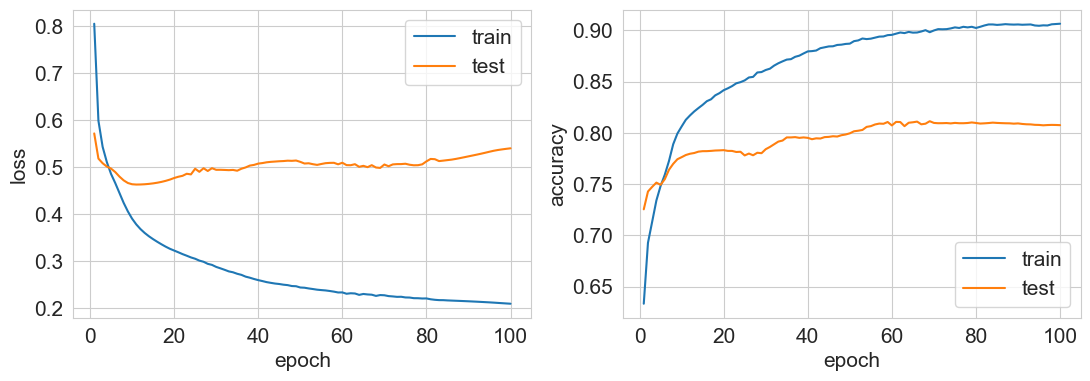

In [91]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [92]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.20987696084872032
test loss 0.540049041892264
train accuracy 0.9063392347230155
test accuracy 0.8074425574425574


In [93]:
class GRU_Classifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.GRU(input_size = in_features, hidden_size = hidden_size, batch_first = True)
        self.head = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        return self.head(out[-1])

In [94]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = GRU_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [95]:
from tqdm.notebook import tqdm
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.shape[0]
        train_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})


  0%|          | 0/100 [00:00<?, ?it/s]

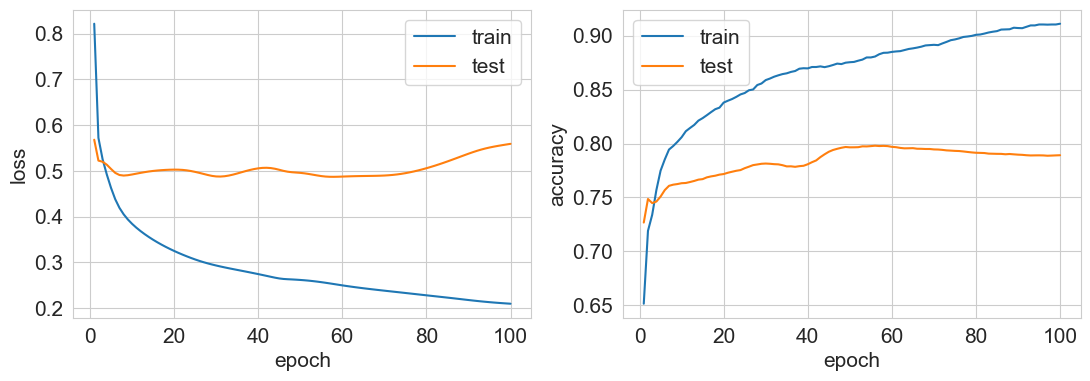

In [96]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [97]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.2096407709740047
test loss 0.5592434911597114
train accuracy 0.9110508280982296
test accuracy 0.7891394319965749


### Моя реализация RNN

In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import tests

In [ ]:
tests.test_RNNcell()

test_RNNCell ... OK


In [110]:
tests.test_RNN()

test_RNN ... OK


In [47]:
tests.test_RNN_Classifier()

test_RNN_CLassifier ... OK


In [57]:
import modules as mm
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = mm.RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, mm.RNN)
optimizer = mm.SGD(model, lr = 0.01, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [58]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy

    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

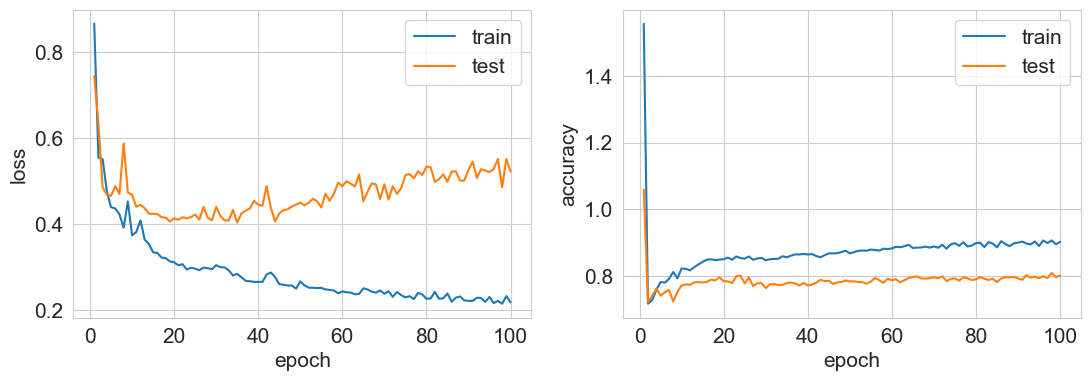

In [59]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [60]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.21876206839893889
test loss 0.5233881938828894
train accuracy 0.9030405140822502
test accuracy 0.8019764986102876


### Моя реализация LSTM

In [114]:
tests.test_LSTMcell()

test_LSTMCell ... OK


In [119]:
tests.test_LSTM()

test_LSTM ... OK


In [133]:
import modules as mm
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = mm.RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, mm.LSTM)
optimizer = mm.SGD(model, lr = 0.01, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [134]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy

    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

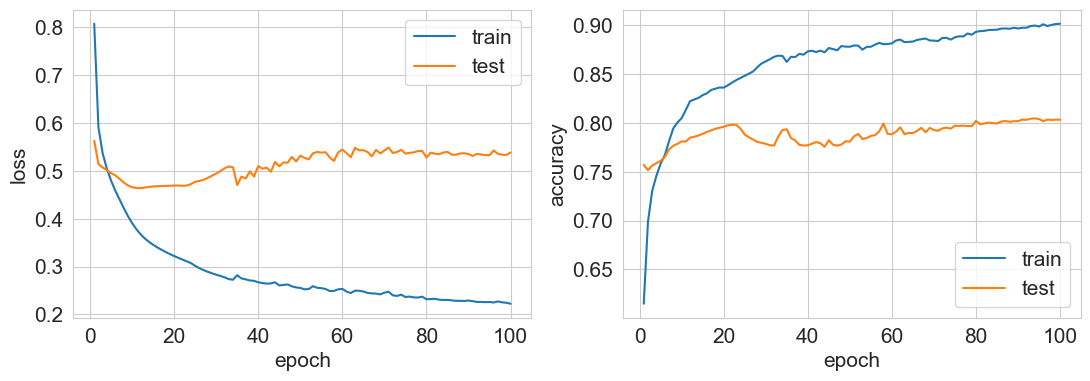

In [135]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [136]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.2224482526270063
test loss 0.5386312167153311
train accuracy 0.9014707574363202
test accuracy 0.8031541077668527


### Моя реализация GRU

In [98]:
tests.test_GRUCell()

test_GRUCell ... OK


In [62]:
tests.test_GRU()

test_GRU ... OK


In [66]:
import modules as mm
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = mm.RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, mm.GRU)
optimizer = mm.SGD(model, lr = 0.01, momentum = 0.9)
criterion = mm.CrossEntropyLoss()

In [67]:
from tqdm.notebook import tqdm
import numpy as np
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in pbar:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        train_loss += loss * X_batch.shape[0]
        train_accuracy += cur_accuracy
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    pbar.set_postfix({'train loss': train_loss, 'test loss': test_loss, 'train accuracy' : train_accuracy, 'test accuracy' : test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

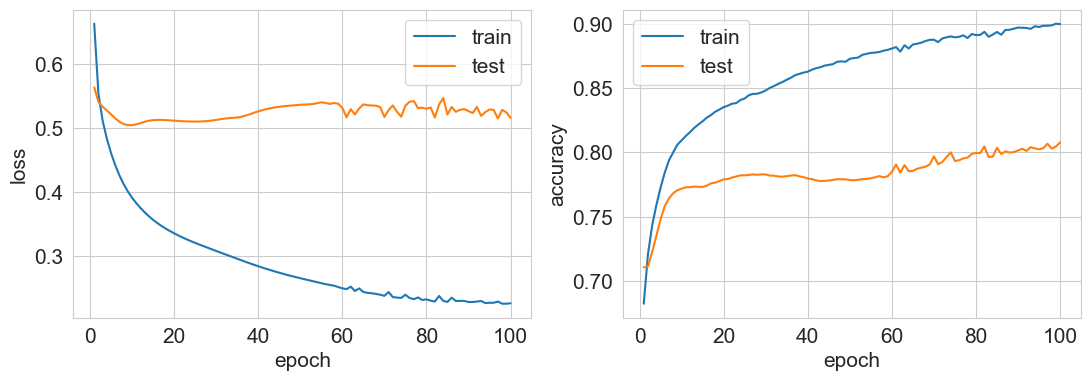

In [68]:
plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [69]:
print('train loss', train_loss)
print('test loss', test_loss)
print('train accuracy',  train_accuracy)
print('test accuracy', test_accuracy)

train loss 0.22646876191144066
test loss 0.5162828424270491
train accuracy 0.8997715591090806
test accuracy 0.8077636649065221
